In [53]:
%load_ext autoreload
%autoreload 2

In [54]:
#| default_exp pascal

# Pascal Darknet Detection
> PASCAL VOC2007

In [110]:
#| export
from minai import *

import torch
import torch.nn as nn
from torch import tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision.transforms.v2.functional as TF
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import v2

from torcheval.metrics import MulticlassAccuracy

import fastcore.all as fc
from fastcore.utils import L
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset, load_dataset_builder

from IPython.display import display, Image

from pilus_project.core import *
from pilus_project.darknet import *

## Data 

### Data loading

In [55]:
set_seed(42)

Let's take a look at VOC2007.

In [67]:
#| export
VOC_CLASSES = L(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
               'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

In [57]:
data_path = fc.Path.home()/'data/'
data_path.ls()

(#3) [Path('/home/kappa/data/VOCtrainval_06-Nov-2007.tar'),Path('/home/kappa/data/VOCdevkit'),Path('/home/kappa/data/pili')]

In [58]:
ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=False)
ds

Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/kappa/data

### Checking out data

What's in the data?

In [59]:
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

In [60]:
#| export
def show_voc_sample(ds, idx, figsize=(12,10)):
    img, target = ds[idx]
    objects = target['annotation']['object']
    img_array = np.array(img)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_array)
    width = int(target['annotation']['size']['width'])
    height = int(target['annotation']['size']['height'])
    for obj in objects:
        bbox = obj['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])
        rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin-5, obj['name'], 
                bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')
    ax.set_title(f"Image {idx}: {', '.join([obj['name'] for obj in objects])}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Image size: {width}x{height}")
    print(f"Number of objects: {len(objects)}")
    for i, obj in enumerate(objects):
        print(f"Object {i+1}: {obj['name']}, Difficult: {obj['difficult']}, Truncated: {obj['truncated']}")

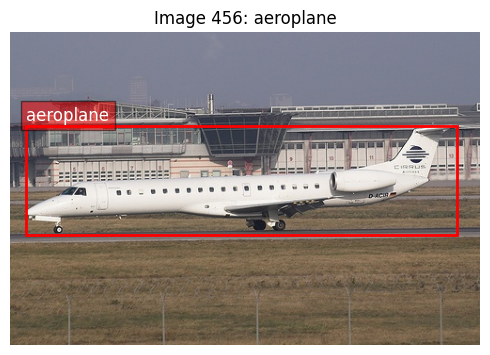

Image size: 500x333
Number of objects: 1
Object 1: aeroplane, Difficult: 0, Truncated: 0


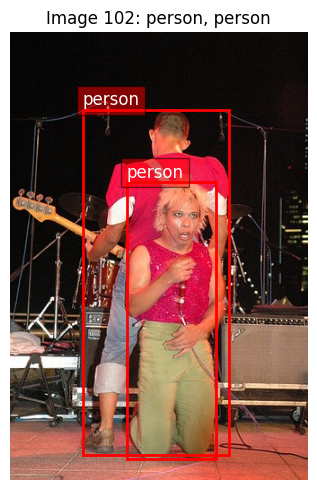

Image size: 332x500
Number of objects: 2
Object 1: person, Difficult: 0, Truncated: 0
Object 2: person, Difficult: 0, Truncated: 0


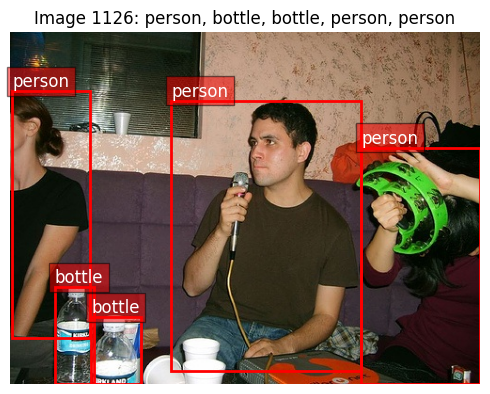

Image size: 500x375
Number of objects: 5
Object 1: person, Difficult: 0, Truncated: 1
Object 2: bottle, Difficult: 0, Truncated: 1
Object 3: bottle, Difficult: 0, Truncated: 1
Object 4: person, Difficult: 0, Truncated: 1
Object 5: person, Difficult: 0, Truncated: 1


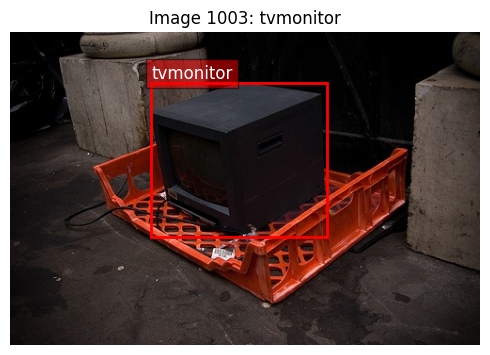

Image size: 500x333
Number of objects: 1
Object 1: tvmonitor, Difficult: 0, Truncated: 0


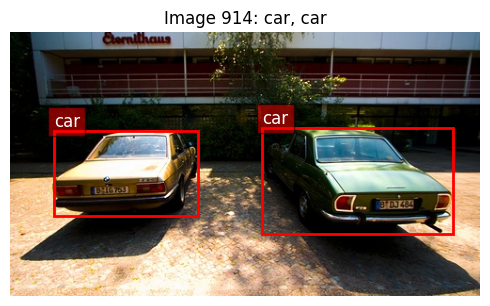

Image size: 500x281
Number of objects: 2
Object 1: car, Difficult: 0, Truncated: 0
Object 2: car, Difficult: 0, Truncated: 0


In [61]:
set_seed(42)
import random
random_indices = random.sample(range(len(ds)), 5)
for idx in random_indices:
    show_voc_sample(ds, idx, figsize=(5,5))

In [62]:
#| export
def get_class_distribution(ds):
    "Get distribution of classes in the dataset"
    counts = {}
    for i in range(len(ds)):
        img, target = ds[i]
        for obj in target['annotation']['object']:
            cls = obj['name']
            counts[cls] = counts.get(cls, 0) + 1
    return pd.Series(counts).sort_values(ascending=False)

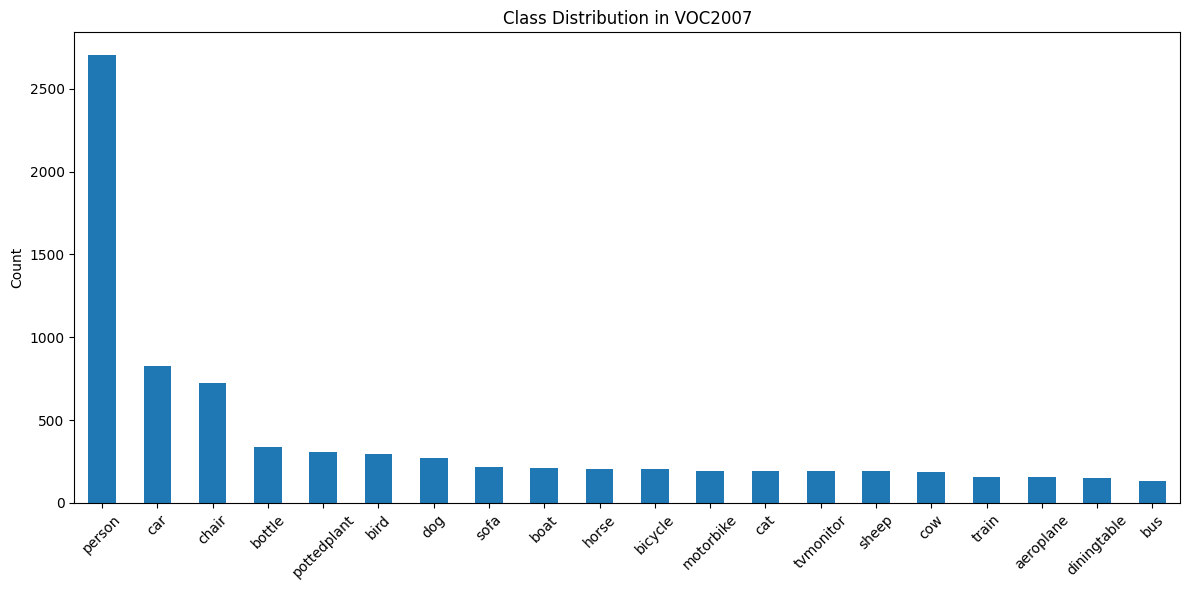

In [ ]:
class_dist = get_class_distribution(ds)
plt.figure(figsize=(12, 6))
class_dist.plot(kind='bar')
plt.title('Class Distribution in VOC2007')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

In [63]:
#| export
def get_image_sizes(ds, n=100):
    "Get distribution of image sizes in the dataset"
    sizes = []
    for i in range(min(n, len(ds))):
        img, _ = ds[i]
        sizes.append(img.size)
    return pd.DataFrame(sizes, columns=['width', 'height'])

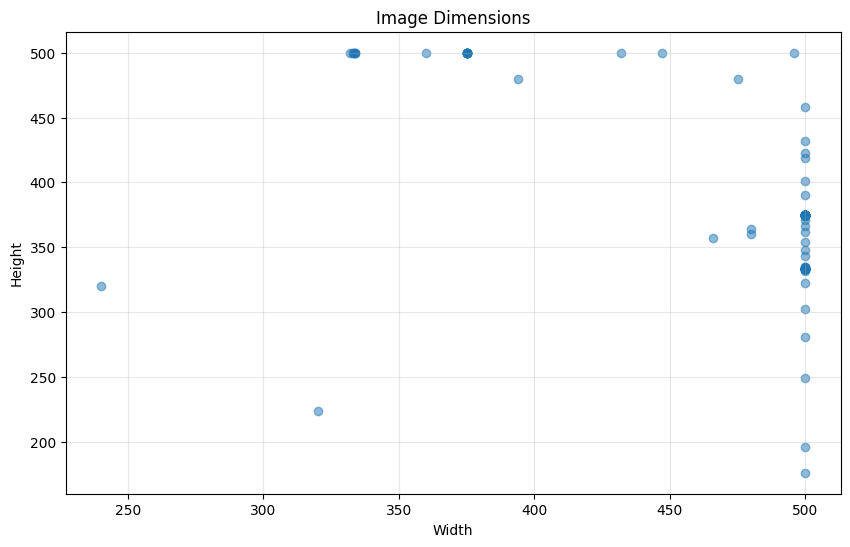

In [64]:
sizes = get_image_sizes(ds)
plt.figure(figsize=(10, 6))
plt.scatter(sizes['width'], sizes['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True, alpha=0.3)

In [65]:
#| export
def show_class_examples(ds, class_name, n=4):
    "Show examples of a specific class"
    examples = []
    for i in range(len(ds)):
        img, target = ds[i]
        if any(obj['name'] == class_name for obj in target['annotation']['object']):
            examples.append((img, target))
            if len(examples) >= n: break
    
    fig, axes = subplots(1, n, figsize=(n*4, 4))
    for i, (img, target) in enumerate(examples):
        axes[i].imshow(img)
        axes[i].set_title(f"Example {i+1}")
        axes[i].axis('off')
        
        for obj in target['annotation']['object']:
            if obj['name'] == class_name:
                bbox = obj['bndbox']
                x1, y1 = int(bbox['xmin']), int(bbox['ymin'])
                x2, y2 = int(bbox['xmax']), int(bbox['ymax'])
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   fill=False, edgecolor='green', linewidth=2)
                axes[i].add_patch(rect)
    
    plt.suptitle(f"Examples of '{class_name}'")
    plt.tight_layout()
    return fig

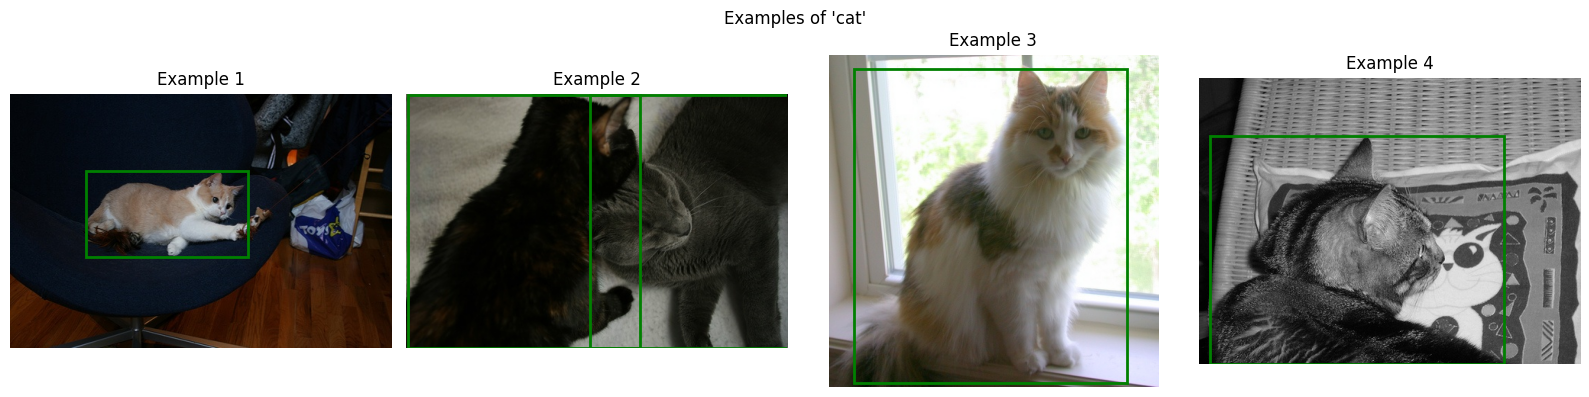

In [68]:
show_class_examples(ds, 'cat');

Text(0, 0.5, 'Number of Images')

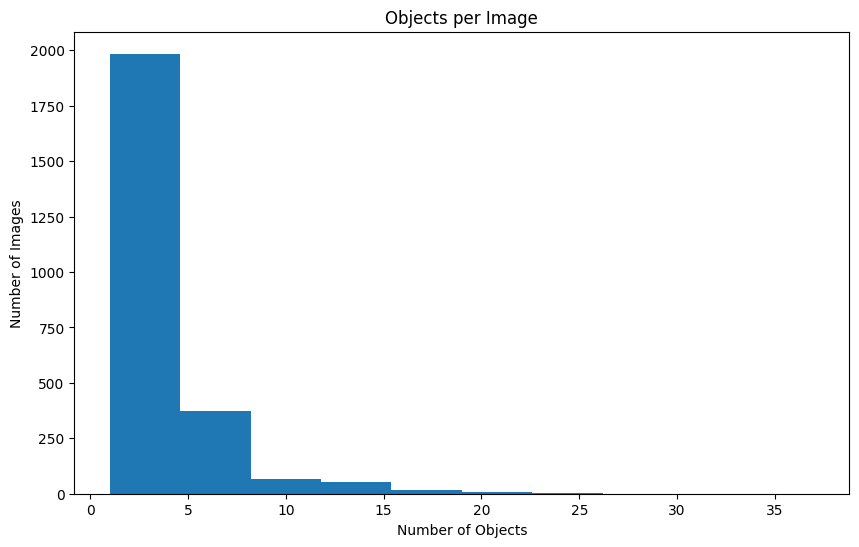

In [ ]:
objects_per_image = [len(ds[i][1]['annotation']['object']) for i in range(len(ds))]
plt.figure(figsize=(10, 6))
plt.hist(objects_per_image, bins=10)
plt.title('Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')

In [70]:
#| export
def calculate_dataset_stats(dataloader, max_images=None):
    """Calculate mean and std of a dataset using a dataloader.
    
    Args:
        dataloader: DataLoader instance
        max_images: Maximum number of images to use (None = use all)
    
    Returns:
        mean and std per channel
    """
    # Create running sums
    channel_sum = torch.zeros(3)
    channel_sum_squared = torch.zeros(3)
    num_pixels = 0
    
    # Use tqdm for progress bar
    from tqdm.auto import tqdm
    
    for i, (images, _) in enumerate(tqdm(dataloader)):
        if max_images is not None and i*dataloader.batch_size >= max_images:
            break
        
        # Make sure images are in the right format
        if not isinstance(images, torch.Tensor):
            continue
            
        # Reshape: [B, C, H, W] -> [B, C, H*W]
        b, c, h, w = images.shape
        images = images.reshape(b, c, -1)
        
        # Update sums
        channel_sum += images.sum(dim=[0, 2])
        channel_sum_squared += (images**2).sum(dim=[0, 2])
        num_pixels += b * h * w
    
    # Calculate mean and std
    mean = channel_sum / num_pixels
    std = torch.sqrt((channel_sum_squared / num_pixels) - (mean**2))
    
    return mean, std

In [71]:
#| export
def get_stats_dataloader(data_path, bs=32, year='2007'):
    """Create a dataloader for calculating dataset statistics"""
    # Basic transforms without normalization
    basic_tfms = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)  # Scales to [0, 1]
    ])
    
    # Create dataset with basic transforms
    ds = datasets.VOCDetection(
        root=data_path, 
        year=year, 
        image_set='train', 
        download=False,
        transform=basic_tfms
    )
    
    # Create a dataloader with a simple collate function that only returns images
    def simple_collate(batch): return torch.stack([item[0] for item in batch]), None
    
    return DataLoader(ds, batch_size=bs, shuffle=False, 
                     collate_fn=simple_collate, num_workers=4)

In [ ]:
stats_dl = get_stats_dataloader(data_path, bs=32)

mean, std = calculate_dataset_stats(stats_dl, max_images=2500)

print(f"Dataset mean: {mean.tolist()}")
print(f"Dataset std: {std.tolist()}")

  0%|          | 0/79 [00:00<?, ?it/s]

Dataset mean: [0.45178133249282837, 0.4230543076992035, 0.39004892110824585]
Dataset std: [0.26676368713378906, 0.261764258146286, 0.2731017470359802]


### Dataset

We create pytorch dataset.

In [72]:
#| export
from torch.utils.data import default_collate
from operator import attrgetter, itemgetter

Pytorch has options to add transforms to its dataset, so this is like `minai`'s `TfmDataset`.

In [73]:
#| export
def create_voc_datasets(data_path, train_tfms=None, valid_tfms=None, year='2007'):
    "Create training and validation datasets for VOC"
    if train_tfms is None:
        train_tfms = v2.Compose([
            v2.RandomResizedCrop(224),
            v2.RandomHorizontalFlip(),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    if valid_tfms is None:
        valid_tfms = v2.Compose([
            v2.Resize(256),
            v2.CenterCrop(224),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    train_ds = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False,
                                    transform=train_tfms)
    valid_ds = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False,
                                   transform=valid_tfms)
    return train_ds, valid_ds

In [74]:
trn_ds, val_ds = create_voc_datasets(data_path)
trn_ds

Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/kappa/data
    StandardTransform
Transform: Compose(
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

The target has many more information than we need. We only need `annotation.object`'s names for classification purposes.

In [75]:
trn_ds[0]

(Image([[[-0.9192, -0.9534, -0.9020,  ..., -1.0048, -0.9705, -1.0048],
         [-0.9192, -0.9363, -0.8849,  ..., -1.0048, -0.9877, -0.9705],
         [-0.9192, -0.9192, -0.9192,  ..., -0.9020, -0.9363, -0.9192],
         ...,
         [-0.8849, -0.8164, -0.8335,  ..., -0.6623, -0.6794, -0.6794],
         [-0.9020, -0.7993, -0.8335,  ..., -0.6794, -0.7137, -0.6452],
         [-0.8507, -0.8507, -0.8164,  ..., -0.6452, -0.6623, -0.6109]],
 
        [[-0.8102, -0.8452, -0.7927,  ..., -0.8803, -0.8452, -0.8803],
         [-0.8102, -0.8277, -0.7752,  ..., -0.8803, -0.8627, -0.8452],
         [-0.8102, -0.8102, -0.8102,  ..., -0.7752, -0.8102, -0.7927],
         ...,
         [-0.7402, -0.6702, -0.6877,  ..., -0.5476, -0.5651, -0.5651],
         [-0.7577, -0.6527, -0.6877,  ..., -0.5651, -0.6001, -0.5301],
         [-0.7052, -0.7052, -0.6702,  ..., -0.5301, -0.5476, -0.4951]],
 
        [[-0.5495, -0.5844, -0.5321,  ..., -0.6193, -0.5844, -0.6193],
         [-0.5495, -0.5670, -0.5147,  ..., 

With `voc_extract`, we can get any field we want from the target.

In [76]:
#| export
def voc_extract(field='name'):
    """Create a function that extracts a specific field from VOC annotations"""
    def _extract(targ):
        return L(fc.nested_attr(targ, 'annotation.object')).itemgot(field)
    return _extract

Object name:

In [77]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, 
    target_transform=voc_extract())
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>, (#1) ['car'])

Bound box:

In [78]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, 
    target_transform=voc_extract(field='bndbox'))
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 (#1) [{'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}])

For training, we actually need one-hot encoded vector because the targets are multi-labels.

In [79]:
VOC_CLASSES

(#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

In [80]:
names = ['car', 'dog']
names

['car', 'dog']

In [81]:
lbls = torch.zeros(len(VOC_CLASSES))
lbls

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

`torch.scatter` is a good way to do this:

In [82]:
onehot = lbls.scatter(0, torch.tensor([1,3,5]), 1)
onehot

tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [83]:
#| export
def onehot_tfm(targ, clss=VOC_CLASSES):
    get = voc_extract(field='name')
    names = get(targ)
    one_hot = torch.zeros(len(clss))
    idxs = tensor([clss.index(n) for n in names])
    one_hot.scatter_(0, idxs, 1)
    return one_hot

In [84]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, 
    target_transform=onehot_tfm)
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

How about going back to label from one hot encoding? We use `np.where`. Why use numpy instead of pytorch? Because `rvs_onehot_tfm` is used for displaying images. We will never use this during training. 

In [85]:
onehot

tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [86]:
np.where(onehot == 1)[0]

array([1, 3, 5])

In [87]:
VOC_CLASSES[np.where(onehot == 1)[0]]

(#3) ['bicycle','boat','bus']

In [88]:
#| export
def _rvs_onehot_tfm(onehot): return VOC_CLASSES[np.where(onehot == 1)[0]]

In [89]:
_rvs_onehot_tfm(onehot)

(#3) ['bicycle','boat','bus']

### DataLoader

We got the dataset, so we are ready to create a dataloader. There are couple transformations we want to apply to images. We have images so far, but we need pytorch tensors with the same image sizes. We also normalize images using imagenet statistics.

In [93]:
to_tensor = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [94]:
trn_ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, 
    transform=to_tensor, target_transform=onehot_tfm)
val_ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='val', download=False, 
    transform=to_tensor, target_transform=onehot_tfm)

In [95]:
bs = 64
multi_label_loss = nn.BCEWithLogitsLoss()

trn_dl, val_dl = get_dls(trn_ds, val_ds, bs=bs)

In [96]:
xb,yb = next(iter(trn_dl))
xb.shape,yb[:10]

(torch.Size([64, 3, 224, 224]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0

Denormalize image before display.

In [100]:
#| export
xmean,xstd = (tensor([0.485, 0.456, 0.406]), tensor([0.229, 0.224, 0.225]))

In [101]:
#| export
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

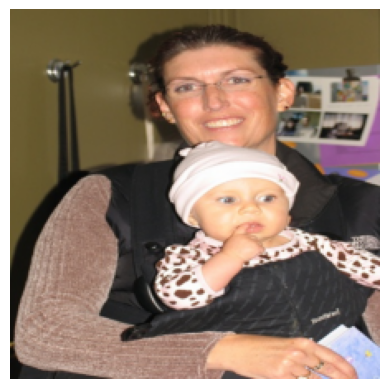

In [102]:
show_image(denorm(xb[0]));

In [103]:
#| export
def get_classification_model(num_classes=len(VOC_CLASSES)):
    "Create a multi-label classification model based on darknet19"
    backbone = get_darknet19()
    model = nn.Sequential(
        backbone,
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

In [105]:
model = get_classification_model()
dls = DataLoaders(trn_dl, val_dl)
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-3, 
                   cbs=[TrainCB(), DeviceCB(), ProgressCB(), MetricsCB()])
learn.summary()

Tot params: 20359636; MFLOPS: 970.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(64, 3, 224, 224)|(64, 1024, 7, 7)|19824576|970.4|
|AdaptiveAvgPool2d|(64, 1024, 7, 7)|(64, 1024, 1, 1)|0|0.0|
|Flatten|(64, 1024, 1, 1)|(64, 1024)|0|0.0|
|Linear|(64, 1024)|(64, 512)|524800|0.5|
|ReLU|(64, 512)|(64, 512)|0|0.0|
|Dropout|(64, 512)|(64, 512)|0|0.0|
|Linear|(64, 512)|(64, 20)|10260|0.0|


We have to patch `show_image_batch` because yb is in GPU when available.

TODO: modify this in `minai`.

In [106]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, tfm_x=None, tfm_y=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    xb,yb = to_cpu(self.batch)
    feat = fc.nested_attr(self.dls, 'train.dataset.features')
    if feat is None: titles = np.array(to_cpu(yb))     # when fitting, yb is in GPU
    else:
        names = feat['label'].names
        titles = [names[i] for i in yb]
    xb = tfm_x(xb[:max_n]) if tfm_x else xb[:max_n]
    titles = tfm_y(titles[:max_n]) if tfm_y else titles[:max_n]
    show_images(xb, titles=titles, **kwargs)

We also have to reverse the transform for the targets. It is in onehot encoding, but we want class names.

In [107]:
yb

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [108]:
[', '.join(_rvs_onehot_tfm(y)) for y in np.array(yb)][:4]

['person', 'chair, person', 'bird', 'dog, person, sofa']

In [109]:
def rvs_onehot_tfm(yb): return [', '.join(_rvs_onehot_tfm(y)) for y in np.array(yb)]

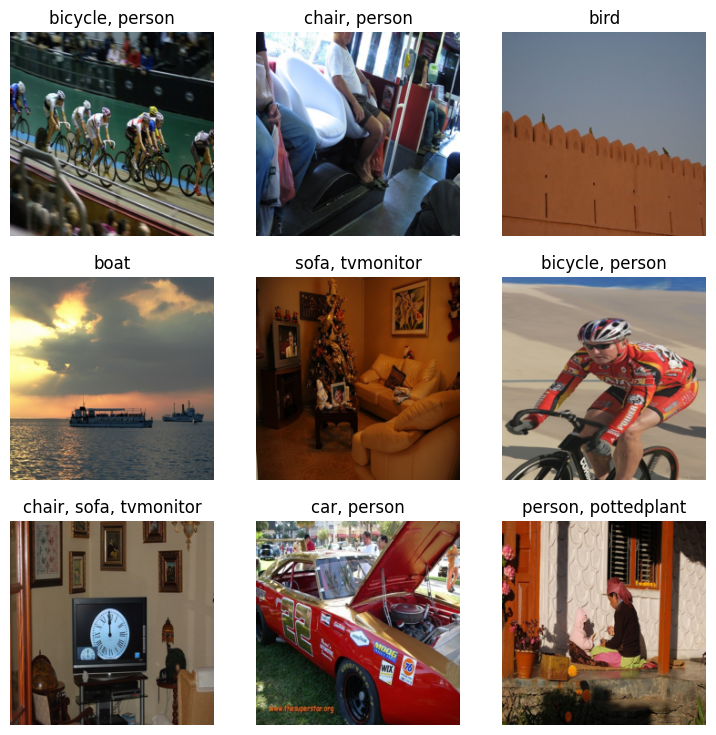

In [41]:
learn.show_image_batch(tfm_x=denorm, tfm_y=rvs_onehot_tfm)

loss,epoch,train,time
0.455,0,train,00:13


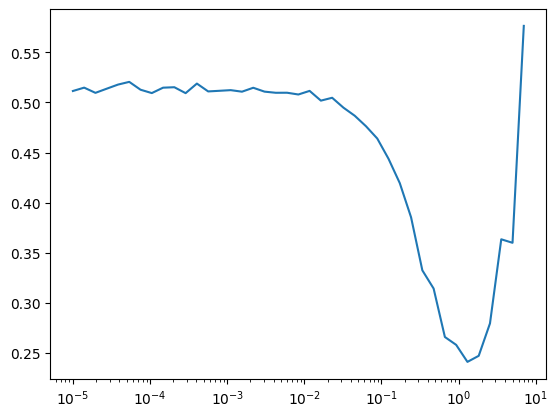

In [ ]:
learn.lr_find(gamma=1.4, max_mult=2)

## Training Classification

In [111]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-1, 
                   cbs=[TrainCB(), DeviceCB(), ProgressCB(), MetricsCB()])

In [112]:
learn.summary()

Tot params: 20359636; MFLOPS: 970.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(64, 3, 224, 224)|(64, 1024, 7, 7)|19824576|970.4|
|AdaptiveAvgPool2d|(64, 1024, 7, 7)|(64, 1024, 1, 1)|0|0.0|
|Flatten|(64, 1024, 1, 1)|(64, 1024)|0|0.0|
|Linear|(64, 1024)|(64, 512)|524800|0.5|
|ReLU|(64, 512)|(64, 512)|0|0.0|
|Dropout|(64, 512)|(64, 512)|0|0.0|
|Linear|(64, 512)|(64, 20)|10260|0.0|


In [ ]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-1, 
                   cbs=[DeviceCB(), ProgressCB(), MetricsCB()])
learn.fit(3)

loss,epoch,train,time
0.371,0,train,00:13
0.261,0,eval,00:54
0.248,1,train,00:13
0.237,1,eval,00:11
0.241,2,train,00:13
0.237,2,eval,00:11


In [48]:
class TopKAccuracy(Callback):
    def __init__(self, k_values=[1, 5], class_names=VOC_CLASSES):
        """
        Implements Top-K accuracy for multi-label classification
        
        Args:
            k_values: List of k values to compute (e.g., [1, 5] for top-1 and top-5)
            class_names: List of class names
        """
        self.k_values = sorted(k_values)
        self.max_k = max(k_values)
        self.class_names = class_names
        
    def before_fit(self, learn):
        self.learn = learn
        
    def before_epoch(self, learn):
        # Initialize counters for each k
        self.correct = {k: 0 for k in self.k_values}
        self.total = 0
        
    def after_batch(self, learn):
        # Get predictions and targets
        logits = to_cpu(learn.preds)
        targets = to_cpu(learn.batch[1])
        batch_size = targets.size(0)
        
        # For each image in the batch
        for i in range(batch_size):
            # Get ground truth classes for this image
            true_classes = torch.where(targets[i] == 1)[0]
            if len(true_classes) == 0:
                continue  # Skip images with no labels
                
            # Get top-k predicted classes
            _, top_indices = torch.topk(logits[i], min(self.max_k, len(self.class_names)))
            
            # Check if any true class is in top-k predictions
            for k in self.k_values:
                top_k_indices = top_indices[:k]
                # For multi-label: if any true class is in top-k predictions, count as correct
                if any(cls in top_k_indices for cls in true_classes):
                    self.correct[k] += 1
            
            self.total += 1
        
    def after_epoch(self, learn):
        phase = 'train' if learn.training else 'valid'
        for k in self.k_values:
            accuracy = self.correct[k] / self.total if self.total > 0 else 0
            print(f"{phase} top-{k} accuracy: {accuracy:.4f}")

In [49]:
# Alternative implementation that considers a prediction correct only if 
# all true classes are in the top-k predictions
class StrictTopKAccuracy(Callback):
    def __init__(self, k_values=[1, 5], class_names=VOC_CLASSES):
        self.k_values = sorted(k_values)
        self.max_k = max(k_values)
        self.class_names = class_names
        
    def before_fit(self, learn):
        self.learn = learn
        
    def before_epoch(self, learn):
        self.correct = {k: 0 for k in self.k_values}
        self.total = 0
        
    def after_batch(self, learn):
        logits = to_cpu(learn.preds)
        targets = to_cpu(learn.batch[1])
        batch_size = targets.size(0)
        
        for i in range(batch_size):
            true_classes = torch.where(targets[i] == 1)[0]
            if len(true_classes) == 0:
                continue
                
            _, top_indices = torch.topk(logits[i], min(self.max_k, len(self.class_names)))
            
            for k in self.k_values:
                if k < len(true_classes):
                    continue  # Can't fit all true classes in top-k if k < number of true classes
                    
                top_k_indices = set(top_indices[:k].tolist())
                true_classes_set = set(true_classes.tolist())
                
                # Strict version: all true classes must be in top-k predictions
                if true_classes_set.issubset(top_k_indices):
                    self.correct[k] += 1
            
            self.total += 1
        
    def after_epoch(self, learn):
        phase = 'train' if learn.training else 'valid'
        for k in self.k_values:
            accuracy = self.correct[k] / self.total if self.total > 0 else 0
            print(f"{phase} strict top-{k} accuracy: {accuracy:.4f}")

In [113]:
#| export
from torcheval.metrics import TopKMultilabelAccuracy
from torcheval.metrics import MultilabelAccuracy
from torcheval.metrics import MultilabelAUPRC

In [114]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-1, 
                   cbs=[DeviceCB(), ProgressCB(), MetricsCB(top5=TopKMultilabelAccuracy(k=5)), 
                        TopKAccuracy(k_values=[1, 5])])

In [ ]:
learn.fit(3)

top5,loss,epoch,train,time
0.000,0.374,0,train,00:13
0.000,0.265,0,eval,00:11
0.000,0.247,1,train,00:13
0.000,0.238,1,eval,00:11
0.000,0.240,2,train,00:13


train top-1 accuracy: 0.3631
train top-5 accuracy: 0.6234
valid top-1 accuracy: 0.4084
valid top-5 accuracy: 0.6657
train top-1 accuracy: 0.4266
train top-5 accuracy: 0.6745
valid top-1 accuracy: 0.4084
valid top-5 accuracy: 0.7032
train top-1 accuracy: 0.4314
train top-5 accuracy: 0.7245


KeyboardInterrupt: 

In [116]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-1, 
                   cbs=[DeviceCB(), ProgressCB(), 
                        MetricsCB(mAP=MultilabelAUPRC(num_labels=20), hamming=MultilabelAccuracy(criteria='hamming'), overlap=MultilabelAccuracy(criteria='overlap'), contain=MultilabelAccuracy(criteria='contain'), belong=MultilabelAccuracy(criteria='belong'),top1=MultilabelAccuracy(criteria='exact_match'), top5=TopKMultilabelAccuracy(criteria='contain', k=5), ), 
                        TopKAccuracy(k_values=[1, 5]), 
                        StrictTopKAccuracy(k_values=[1, 5])])

In [117]:
learn.fit(5)

mAP,hamming,overlap,contain,belong,top1,top5,loss,epoch,train,time
0.085,0.920,0.002,0.001,0.998,0.001,0.299,0.374,0,train,03:34
0.103,0.922,0.000,0.000,1.000,0.000,0.362,0.263,0,eval,01:20
0.099,0.920,0.006,0.001,0.995,0.001,0.355,0.249,1,train,03:20
0.149,0.922,0.000,0.000,1.000,0.000,0.423,0.238,1,eval,01:14


train top-1 accuracy: 0.3894
train top-5 accuracy: 0.6301
train strict top-1 accuracy: 0.0768
train strict top-5 accuracy: 0.2991
valid top-1 accuracy: 0.4084
valid top-5 accuracy: 0.7040
valid strict top-1 accuracy: 0.0797
valid strict top-5 accuracy: 0.3622
train top-1 accuracy: 0.4278
train top-5 accuracy: 0.6853
train strict top-1 accuracy: 0.0832
train strict top-5 accuracy: 0.3555
valid top-1 accuracy: 0.4084
valid top-5 accuracy: 0.7104
valid strict top-1 accuracy: 0.0797
valid strict top-5 accuracy: 0.4231


KeyboardInterrupt: 

In [118]:
#| hide
import nbdev; nbdev.nbdev_export()